In [1]:
!pip uninstall -y numpy
!pip install numpy==1.26.4 --upgrade --force-reinstall --quiet

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 37.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:
import numpy as np
print(np.__version__)

1.26.4


In [2]:
#Install dependencies
!pip install pennylane pennylane-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 14.7 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [31]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

import math
import re
import pandas as pd
import numpy as np
import time
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import pennylane as qml

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

In [32]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Data Loading and Preprocessing**

In [33]:
with open("/content/drive/MyDrive/QML-Research/Data/sentiment labelled sentences/amazon_cells_labelled.txt", "r") as f:
    lines = f.readlines()

sentences = [line.split("\t")[0] for line in lines]
labels = [int(line.split("\t")[1]) for line in lines]

In [36]:
print(f"0 Labels: {labels.count(0)}")
print(f"1 Labels: {labels.count(1)}")

0 Labels: 500
1 Labels: 500


In [34]:
len(sentences)

1000

In [7]:
def stopword_tokenize(sequence):
  sequence = re.sub(r"[^\w\s]", "", sequence.lower())
  tokens = sequence.split()
  return [word for word in tokens if word not in stop_words]

cleaned_sents = [stopword_tokenize(sentence) for sentence in sentences]

# **EDA**

Sentence Lengths:
min = 1
max = 17
mean = 5.36
95th percentile = 12.0



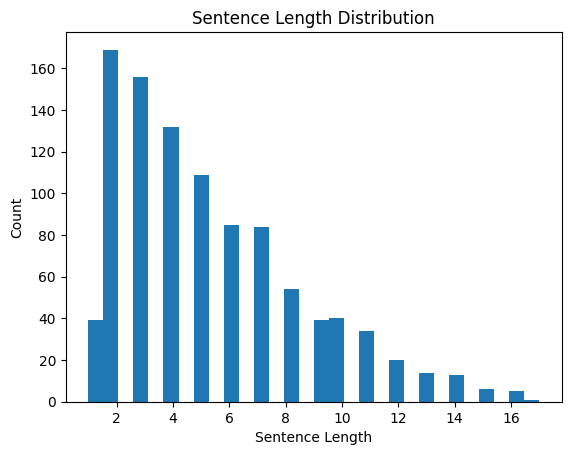

In [8]:
lengths = [len(s) for s in cleaned_sents]
print(f"Sentence Lengths:\nmin = {np.min(lengths)}\nmax = {np.max(lengths)}\nmean = {np.mean(lengths):.2f}\n95th percentile = {np.percentile(lengths, 95)}")
print()
plt.hist(lengths, bins = 30)
plt.title("Sentence Length Distribution")
plt.xlabel("Sentence Length")
plt.ylabel("Count")
plt.show()

# **Padding and Truncation**

In [9]:
max_len = 10
for i in range(len(cleaned_sents)):
  if (len(cleaned_sents[i]) < max_len):
    cleaned_sents[i] += ["<PAD>"] * (max_len - len(cleaned_sents[i]))
  else:
    cleaned_sents[i] = cleaned_sents[i][:max_len]

# **BOW Approach**

In [ ]:
vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(sentences).toarray()
X = torch.tensor(X).float()
y = torch.tensor(labels).float()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Word Embeddings approach**

In [ ]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
cleaned_sents_str = [" ".join(tokens) for tokens in cleaned_sents]

X_embed = embedding_model.encode(cleaned_sents_str)
X_embed = torch.tensor(X_embed).float()
y_embed = torch.tensor(labels).float()

In [ ]:
df = pd.DataFrame({
    "original_sentence": sentences,
    "cleaned_sentence": cleaned_sents_str,
    "label": labels
})

df.to_csv("preprocessed_dataset.csv", index=False)

# **Manual GloVe Embedding**

In [10]:
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

In [11]:
def sentence_to_vec(sentence, embeddings, dim):
    vectors = []
    for word in sentence:
        if word in embeddings:
            vectors.append(embeddings[word])
        else:
            vectors.append(np.zeros(dim))
    return vectors

In [12]:
def embed_sentences(cleaned_sents, embeddings, dim=5):
    return np.array([sentence_to_vec(tokens, embeddings, dim) for tokens in cleaned_sents])

In [13]:
glove_path = '/content/drive/MyDrive/QML-Research/Data/glove.6B.100d.txt'
glove = load_glove_embeddings(glove_path)

# **PCA**

In [14]:
all_words = list(glove.keys())
all_vectors = np.array([glove[word] for word in all_words])
# pca = PCA(n_components=5, random_state=42)
# pca = PCA(n_components=15, random_state=42)
pca = PCA(n_components=32, random_state=42)
reduced_vectors = pca.fit_transform(all_vectors)
reduced_embeddings = {word: reduced_vectors[i] for i, word in enumerate(all_words)}

# **Word Encoding**

In [15]:
# X_embed_np = embed_sentences(cleaned_sents, reduced_embeddings, dim=5)
# X_embed_np = embed_sentences(cleaned_sents, reduced_embeddings, dim=15)
X_embed_np = embed_sentences(cleaned_sents, reduced_embeddings, dim=32)
X_embed = torch.tensor(X_embed_np).float()
y_embed = torch.tensor(labels).float()

In [16]:
X_embed[0]

tensor([[-5.1434e+00,  1.2269e-01, -9.9965e-02,  8.1665e-01, -7.2092e-02,
          1.9693e+00,  1.4129e-01,  4.9388e-01, -3.2231e-01,  6.5924e-01,
         -9.9895e-01,  1.1870e-01, -2.0301e-01,  3.5686e-01, -2.9018e-02,
          1.9936e-01, -6.9530e-01,  2.5739e-01,  3.4662e-01, -1.2635e-01,
          1.8321e-02, -1.6034e-01,  8.6802e-02,  8.6058e-02,  1.8270e-01,
          1.4415e-01,  2.6510e-01,  3.0772e-01, -1.7399e-01,  1.3690e-01,
          4.2661e-02,  2.5137e-01],
        [-2.6515e+00, -7.0814e-01, -2.8305e-01,  2.8472e-01, -3.6879e-01,
          7.2527e-01, -1.0879e-01,  6.1020e-02,  6.5912e-01,  1.1538e-01,
         -1.5700e-01,  7.6759e-01,  2.0213e-01,  1.3268e+00, -1.5796e+00,
          2.8325e-01, -3.8706e-01,  8.1515e-01,  4.3449e-01, -1.3116e-01,
          2.2726e-01,  5.4945e-01,  1.1203e-01, -1.6181e-01,  2.0447e-01,
         -5.1329e-01, -1.5652e-02,  5.5695e-01, -4.0126e-01,  9.8258e-02,
          1.3588e-01, -9.9213e-01],
        [-5.1575e+00, -3.5955e-01, -3.78

# **DataLoader**

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_embed, y_embed, test_size=0.2, random_state=42)

In [18]:
class AmazonDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [19]:
small_train_dataset = Subset(AmazonDataset(X_train, y_train), list(range(100)))
train_loader_small = DataLoader(small_train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(AmazonDataset(X_test, y_test), batch_size=1)

In [20]:
len(test_loader)

200

In [21]:
xbtemp, ybtemp = next(iter(train_loader_small))
xbtemp

tensor([[[-3.5909e+00,  2.5066e-01, -3.5235e-01, -2.6059e-01, -5.2569e-01,
           2.1643e+00,  1.2377e-01, -1.4628e-01, -1.5233e-01,  8.0387e-01,
          -2.3695e-01,  5.3273e-01, -2.8278e-01,  6.4641e-01, -8.1236e-01,
           9.8459e-02, -3.6603e-01,  3.3365e-01, -6.4946e-01,  1.4754e+00,
          -6.9389e-01,  1.0101e+00,  3.8586e-01, -1.0336e-01,  2.6911e-01,
          -1.2856e+00,  1.1547e-01,  4.3415e-01, -7.4635e-01, -2.1545e-01,
           1.0871e+00,  2.9851e-01],
         [-3.5539e+00, -1.4025e-01, -8.8389e-01,  7.7324e-01, -5.6430e-01,
           2.0528e+00,  4.6357e-01,  1.1209e-01,  4.1424e-01,  8.3290e-01,
          -1.2644e+00,  5.6920e-02,  8.1895e-01,  7.0984e-01,  2.3433e-01,
           1.2067e-01, -6.4197e-01, -2.3276e-03, -3.1282e-02,  8.2581e-01,
          -3.6517e-01,  1.4477e-01,  7.0327e-02,  1.7163e-01,  1.0683e-01,
           3.1715e-01,  4.0630e-01,  1.0507e+00, -9.0112e-03,  5.3061e-01,
          -1.6010e-01,  1.0148e-01],
         [-3.3392e+00,  5.

In [22]:
xbtemp[0][0][0]

tensor(-3.5909)

# **Quantum Circuit and Model**

In [ ]:
n_qubits = 6
dev = qml.device("lightning.qubit", wires=n_qubits, shots=None)
# dev = qml.device("default.qubit", wires=n_qubits, shots=None)

In [ ]:
@qml.qnode(dev, interface="torch")
def quantum_step(inputs, hidden, weights_in, weights_h):
    inputs_norm = inputs / (torch.norm(inputs) + 1e-8)

    for i in range(5):
        qml.RY(inputs_norm[i], wires=i)

    qml.RY(hidden, wires=5)

    for i in range(5):
        qml.CNOT(wires=[i, (i + 1) % 5])

    for i in range(5):
        qml.RY(weights_in[i], wires=i)

    qml.RY(weights_h[0], wires=5)
    return qml.expval(qml.PauliZ(5))

In [ ]:
class QuantumRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Linear(5, 5)
        self.weights_in = nn.Parameter(torch.randn(5) * 0.1)
        self.weights_h = nn.Parameter(torch.randn(1) * 0.1)
        self.classifier = nn.Linear(1, 1)

    def forward(self, x):
        seq_len = x.shape[0]
        hidden = torch.tensor(0.0, requires_grad=True)

        for t in range(seq_len):
            input_t = self.embedding(x[t])
            hidden = quantum_step(input_t, hidden, self.weights_in, self.weights_h)

        out = self.classifier(hidden.unsqueeze(0))
        return out

In [ ]:
model = QuantumRNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

# **Training Loop**

In [ ]:
start_time = time.time()
epochs = 50
model.train()

for epoch in range(epochs):
    total_loss = 0
    correct = 0
    total = 0
    epoch_start = time.time()

    for xb, yb in train_loader_small:
        xb = xb.squeeze(0)
        yb = yb.squeeze()

        optimizer.zero_grad()
        output = model(xb)

        output_flat = output.squeeze()
        yb_flat = yb.float()

        loss = loss_fn(output_flat, yb_flat)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        predicted = (torch.sigmoid(output_flat) > 0.5).float()
        correct += (predicted == yb_flat).sum().item()
        total += 1

    avg_loss = total_loss / len(train_loader_small)
    epoch_time = time.time() - epoch_start
    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    print(f"Time for epoch: {epoch_time:.2f} seconds")

total_time = time.time() - start_time
print(f"\nTotal training time: {total_time:.2f} seconds")

# **Testing Loop**

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.squeeze(0)
        yb = yb.squeeze()
        logits = model(xb)
        logits_flat = logits.squeeze()
        prob = torch.sigmoid(logits_flat)
        pred = (prob > 0.5).float()
        actual = yb.float()

        if pred == actual:
            correct += 1
        total += 1

        if total <= 10:
            print(f"Logit: {logits_flat.item():.3f} | Probability: {prob.item():.3f} | Pred: {pred.item()}, Actual: {actual.item()}")

print(f"Test Accuracy: {correct / total * 100:.2f}%")

# **Dense Angle Encoding**
- **Encodes 15 dimensions using just 3 qubits**

In [ ]:
n_qubits = 4
dev = qml.device("lightning.qubit", wires=n_qubits, shots=None)

In [ ]:
@qml.qnode(dev, interface="torch")
def quantum_step(inputs, hidden, weights_in, weights_h):
    for i in range(5):
        qml.RY(inputs[i], wires=0)
        qml.RZ(inputs[i] * 0.5, wires=0)

    for i in range(5, 10):
        qml.RY(inputs[i], wires=1)
        qml.RZ(inputs[i] * 0.5, wires=1)

    for i in range(10, 15):
        qml.RY(inputs[i], wires=2)
        qml.RZ(inputs[i] * 0.5, wires=2)

    qml.RY(hidden, wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

    for i in range(3):
        qml.RY(weights_in[i], wires=i)
        qml.RZ(weights_in[i + 3], wires=i)

    qml.RY(weights_h[0], wires=3)
    return qml.expval(qml.PauliZ(3))

In [ ]:
class QuantumRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Linear(15, 15)
        self.weights_in = nn.Parameter(torch.randn(6) * 0.1)
        self.weights_h = nn.Parameter(torch.randn(1) * 0.1)
        self.classifier = nn.Linear(1, 1)

    def forward(self, x):
        seq_len = x.shape[0]
        hidden = torch.tensor(0.0, requires_grad=True)

        for t in range(seq_len):
            input_t = self.embedding(x[t])
            hidden = quantum_step(input_t, hidden, self.weights_in, self.weights_h)

        out = self.classifier(hidden.unsqueeze(0))
        return out

In [ ]:
model = QuantumRNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

weights_in: torch.Size([6])
weights_h: torch.Size([1])
embedding.weight: torch.Size([15, 15])
embedding.bias: torch.Size([15])
classifier.weight: torch.Size([1, 1])
classifier.bias: torch.Size([1])


In [ ]:
start_time = time.time()
epochs = 50
model.train()

for epoch in range(epochs):
    total_loss = 0
    correct = 0
    total = 0
    epoch_start = time.time()

    for xb, yb in train_loader_small:
        xb = xb.squeeze(0)
        yb = yb.squeeze()

        optimizer.zero_grad()
        output = model(xb)

        output_flat = output.squeeze()
        yb_flat = yb.float()

        loss = loss_fn(output_flat, yb_flat)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = (torch.sigmoid(output_flat) > 0.5).float()
        correct += (predicted == yb_flat).sum().item()
        total += 1

    avg_loss = total_loss / len(train_loader_small)
    epoch_time = time.time() - epoch_start
    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    print(f"Time for epoch: {epoch_time:.2f} seconds")

total_time = time.time() - start_time
print(f"\nTotal training time: {total_time:.2f} seconds")

Epoch 1, Loss: 0.7099, Accuracy: 46.00%
Time for epoch: 10.28 seconds
Epoch 2, Loss: 0.6954, Accuracy: 51.00%
Time for epoch: 12.73 seconds
Epoch 3, Loss: 0.6944, Accuracy: 53.00%
Time for epoch: 18.07 seconds
Epoch 4, Loss: 0.6926, Accuracy: 53.00%
Time for epoch: 12.29 seconds
Epoch 5, Loss: 0.6946, Accuracy: 53.00%
Time for epoch: 10.39 seconds
Epoch 6, Loss: 0.6927, Accuracy: 52.00%
Time for epoch: 12.11 seconds
Epoch 7, Loss: 0.6934, Accuracy: 53.00%
Time for epoch: 10.84 seconds
Epoch 8, Loss: 0.6934, Accuracy: 53.00%
Time for epoch: 9.52 seconds
Epoch 9, Loss: 0.6930, Accuracy: 53.00%
Time for epoch: 10.66 seconds
Epoch 10, Loss: 0.6929, Accuracy: 53.00%
Time for epoch: 10.57 seconds
Epoch 11, Loss: 0.6927, Accuracy: 53.00%
Time for epoch: 10.39 seconds
Epoch 12, Loss: 0.6937, Accuracy: 53.00%
Time for epoch: 10.18 seconds
Epoch 13, Loss: 0.6937, Accuracy: 53.00%
Time for epoch: 10.74 seconds
Epoch 14, Loss: 0.6932, Accuracy: 53.00%
Time for epoch: 10.43 seconds
Epoch 15, Loss: 

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.squeeze(0)
        yb = yb.squeeze()

        logits = model(xb)
        logits_flat = logits.squeeze()
        prob = torch.sigmoid(logits_flat)
        pred = (prob > 0.5).float()
        actual = yb.float()

        if pred == actual:
            correct += 1
        total += 1

        if total <= 10:
            print(f"Logit: {logits_flat.item():.3f} | Probability: {prob.item():.3f} | Pred: {pred.item()}, Actual: {actual.item()}")

print(f"Test Accuracy: {correct / total * 100:.2f}%")

Logit: -0.109 | Probability: 0.473 | Pred: 0.0, Actual: 1.0
Logit: -0.112 | Probability: 0.472 | Pred: 0.0, Actual: 1.0
Logit: -0.110 | Probability: 0.473 | Pred: 0.0, Actual: 1.0
Logit: -0.069 | Probability: 0.483 | Pred: 0.0, Actual: 0.0
Logit: -0.110 | Probability: 0.473 | Pred: 0.0, Actual: 1.0
Logit: -0.116 | Probability: 0.471 | Pred: 0.0, Actual: 1.0
Logit: -0.110 | Probability: 0.473 | Pred: 0.0, Actual: 0.0
Logit: 0.019 | Probability: 0.505 | Pred: 1.0, Actual: 1.0
Logit: -0.109 | Probability: 0.473 | Pred: 0.0, Actual: 0.0
Logit: -0.110 | Probability: 0.473 | Pred: 0.0, Actual: 1.0
Test Accuracy: 47.50%


# **Amplitude Encoding**
- Amplitude encodes an input with dimension of 23 with just 5 qubits, after normalizing the input (Input Normalization is necessary for amplitude encoding)

In [ ]:
n_qubits = 6
dev = qml.device("lightning.qubit", wires=n_qubits, shots=None)

In [ ]:
@qml.qnode(dev, interface="torch")
def quantum_step(inputs, hidden, weights_in, weights_h):

    inputs_clean = torch.where(torch.isnan(inputs) | torch.isinf(inputs),
                              torch.zeros_like(inputs), inputs)

    inputs_clean = inputs_clean + torch.randn_like(inputs_clean) * 1e-6

    norm = torch.sqrt(torch.sum(inputs_clean**2) + 1e-8)
    inputs_normalized = inputs_clean / norm

    final_norm = torch.sqrt(torch.sum(inputs_normalized**2))
    if torch.isnan(final_norm) or torch.abs(final_norm - 1.0) > 1e-3:
        inputs_normalized = torch.ones_like(inputs_clean) / torch.sqrt(torch.tensor(32.0))

    inputs_np = inputs_normalized.detach().numpy()

    qml.AmplitudeEmbedding(features=inputs_np, wires=range(5), normalize=False)

    qml.RY(hidden, wires=5)

    for i in range(5):
        qml.CNOT(wires=[i, 5])

    for i in range(5):
        qml.CNOT(wires=[i, (i + 1) % 5])

    for i in range(5):
        qml.RY(weights_in[i], wires=i)
        qml.RZ(weights_in[i + 5], wires=i)

    qml.RY(weights_h[0], wires=5)
    qml.RZ(weights_h[1], wires=5)

    return qml.expval(qml.PauliZ(5))

In [ ]:
class QuantumRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Linear(32, 32)
        self.weights_in = nn.Parameter(torch.randn(10) * 0.1)
        self.weights_h = nn.Parameter(torch.randn(2) * 0.1)
        self.classifier = nn.Linear(1, 1)

    def forward(self, x):
        seq_len = x.shape[0]
        hidden = torch.tensor(0.0, requires_grad=True)

        for t in range(seq_len):
            input_t = self.embedding(x[t])
            hidden = quantum_step(input_t, hidden, self.weights_in, self.weights_h)

        out = self.classifier(hidden.unsqueeze(0))
        return out

In [ ]:
model = QuantumRNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

weights_in: torch.Size([10])
weights_h: torch.Size([2])
embedding.weight: torch.Size([32, 32])
embedding.bias: torch.Size([32])
classifier.weight: torch.Size([1, 1])
classifier.bias: torch.Size([1])


In [ ]:
start_time = time.time()
epochs = 50
model.train()

for epoch in range(epochs):
    total_loss = 0
    correct = 0
    total = 0
    epoch_start = time.time()

    for xb, yb in train_loader_small:
        xb = xb.squeeze(0)
        yb = yb.squeeze()

        optimizer.zero_grad()
        output = model(xb)

        output_flat = output.squeeze()
        yb_flat = yb.float()

        loss = loss_fn(output_flat, yb_flat)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = (torch.sigmoid(output_flat) > 0.5).float()
        correct += (predicted == yb_flat).sum().item()
        total += 1

    avg_loss = total_loss / len(train_loader_small)
    epoch_time = time.time() - epoch_start
    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    print(f"Time for epoch: {epoch_time:.2f} seconds")

total_time = time.time() - start_time
print(f"\nTotal training time: {total_time:.2f} seconds")

Epoch 1, Loss: 0.7273, Accuracy: 47.00%
Time for epoch: 6.56 seconds
Epoch 2, Loss: 0.7052, Accuracy: 46.00%
Time for epoch: 5.60 seconds
Epoch 3, Loss: 0.6969, Accuracy: 46.00%
Time for epoch: 6.66 seconds
Epoch 4, Loss: 0.6955, Accuracy: 48.00%
Time for epoch: 8.10 seconds
Epoch 5, Loss: 0.6946, Accuracy: 50.00%
Time for epoch: 6.63 seconds
Epoch 6, Loss: 0.6939, Accuracy: 50.00%
Time for epoch: 6.33 seconds
Epoch 7, Loss: 0.6944, Accuracy: 51.00%
Time for epoch: 6.65 seconds
Epoch 8, Loss: 0.6948, Accuracy: 50.00%
Time for epoch: 5.68 seconds
Epoch 9, Loss: 0.6942, Accuracy: 51.00%
Time for epoch: 6.82 seconds
Epoch 10, Loss: 0.6945, Accuracy: 50.00%
Time for epoch: 5.54 seconds
Epoch 11, Loss: 0.6964, Accuracy: 51.00%
Time for epoch: 6.53 seconds
Epoch 12, Loss: 0.6931, Accuracy: 52.00%
Time for epoch: 5.66 seconds
Epoch 13, Loss: 0.6947, Accuracy: 52.00%
Time for epoch: 6.62 seconds
Epoch 14, Loss: 0.6928, Accuracy: 52.00%
Time for epoch: 5.58 seconds
Epoch 15, Loss: 0.6943, Accur

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.squeeze(0)
        yb = yb.squeeze()

        logits = model(xb)
        logits_flat = logits.squeeze()
        prob = torch.sigmoid(logits_flat)
        pred = (prob > 0.5).float()
        actual = yb.float()

        if pred == actual:
            correct += 1
        total += 1

        if total <= 10:
            print(f"Logit: {logits_flat.item():.3f} | Probability: {prob.item():.3f} | Pred: {pred.item()}, Actual: {actual.item()}")

print(f"Test Accuracy: {correct / total * 100:.2f}%")

Logit: -0.119 | Probability: 0.470 | Pred: 0.0, Actual: 1.0
Logit: -0.118 | Probability: 0.470 | Pred: 0.0, Actual: 1.0
Logit: -0.119 | Probability: 0.470 | Pred: 0.0, Actual: 1.0
Logit: -0.118 | Probability: 0.471 | Pred: 0.0, Actual: 0.0
Logit: -0.119 | Probability: 0.470 | Pred: 0.0, Actual: 1.0
Logit: -0.112 | Probability: 0.472 | Pred: 0.0, Actual: 1.0
Logit: -0.119 | Probability: 0.470 | Pred: 0.0, Actual: 0.0
Logit: -0.157 | Probability: 0.461 | Pred: 0.0, Actual: 1.0
Logit: -0.119 | Probability: 0.470 | Pred: 0.0, Actual: 0.0
Logit: -0.119 | Probability: 0.470 | Pred: 0.0, Actual: 1.0
Test Accuracy: 46.50%


# **Amplitude + Angle Encoding**

In [23]:
n_qubits = 8
dev = qml.device("lightning.qubit", wires=n_qubits, shots=None)

In [24]:
@qml.qnode(dev, interface="torch")
def quantum_step(inputs, hidden, weights_in, weights_h):

    amplitude_features = inputs[:16]
    angle_features = inputs[16:32]

    amp_clean = torch.where(torch.isnan(amplitude_features) | torch.isinf(amplitude_features),
                           torch.zeros_like(amplitude_features), amplitude_features)

    amp_clean = amp_clean + torch.randn_like(amp_clean) * 1e-6

    amp_norm = torch.sqrt(torch.sum(amp_clean**2) + 1e-8)
    amp_normalized = amp_clean / amp_norm

    final_norm = torch.sqrt(torch.sum(amp_normalized**2))
    if torch.isnan(final_norm) or torch.abs(final_norm - 1.0) > 1e-3:
        amp_normalized = torch.ones_like(amp_clean) / torch.sqrt(torch.tensor(16.0))

    amp_np = amp_normalized.detach().numpy()

    qml.AmplitudeEmbedding(features=amp_np, wires=range(4), normalize=False)

    for i in range(5):
        if i < len(angle_features):
            qml.RY(angle_features[i], wires=4)
            qml.RZ(angle_features[i] * 0.7, wires=4)

    for i in range(5, 11):
        if i < len(angle_features):
            qml.RY(angle_features[i], wires=5)
            qml.RZ(angle_features[i] * 0.7, wires=5)

    for i in range(11, 16):
        if i < len(angle_features):
            qml.RY(angle_features[i], wires=6)
            qml.RZ(angle_features[i] * 0.7, wires=6)

    qml.RY(hidden, wires=7)

    for i in range(3):
        qml.CNOT(wires=[i, i+1])

    qml.CNOT(wires=[4, 5])
    qml.CNOT(wires=[5, 6])

    qml.CNOT(wires=[3, 4])
    qml.CNOT(wires=[6, 7])

    qml.CNOT(wires=[0, 7])
    qml.CNOT(wires=[4, 7])

    for i in range(4):
        qml.RY(weights_in[i], wires=i)
        qml.RZ(weights_in[i + 4], wires=i)

    for i in range(3):
        qml.RY(weights_in[i + 8], wires=i + 4)
        qml.RZ(weights_in[i + 11], wires=i + 4)

    qml.RY(weights_h[0], wires=7)
    qml.RZ(weights_h[1], wires=7)

    return qml.expval(qml.PauliZ(7))

In [25]:
class QuantumRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Linear(32, 32)
        self.weights_in = nn.Parameter(torch.randn(14) * 0.1)
        self.weights_h = nn.Parameter(torch.randn(2) * 0.1)
        self.classifier = nn.Linear(1, 1)

    def forward(self, x):
        seq_len = x.shape[0]
        hidden = torch.tensor(0.0, requires_grad=True)

        for t in range(seq_len):
            input_t = self.embedding(x[t])
            hidden = quantum_step(input_t, hidden, self.weights_in, self.weights_h)

        out = self.classifier(hidden.unsqueeze(0))
        return out

In [26]:
# Initialize model
model = QuantumRNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()

In [27]:
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

weights_in: torch.Size([14])
weights_h: torch.Size([2])
embedding.weight: torch.Size([32, 32])
embedding.bias: torch.Size([32])
classifier.weight: torch.Size([1, 1])
classifier.bias: torch.Size([1])


In [28]:
start_time = time.time()
epochs = 50
model.train()

for epoch in range(epochs):
    total_loss = 0
    correct = 0
    total = 0
    epoch_start = time.time()

    for xb, yb in train_loader_small:
        xb = xb.squeeze(0)
        yb = yb.squeeze()

        optimizer.zero_grad()
        output = model(xb)

        output_flat = output.squeeze()
        yb_flat = yb.float()

        loss = loss_fn(output_flat, yb_flat)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = (torch.sigmoid(output_flat) > 0.5).float()
        correct += (predicted == yb_flat).sum().item()
        total += 1

    avg_loss = total_loss / len(train_loader_small)
    epoch_time = time.time() - epoch_start
    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    print(f"Time for epoch: {epoch_time:.2f} seconds")

total_time = time.time() - start_time
print(f"\nTotal training time: {total_time:.2f} seconds")

Epoch 1, Loss: 0.7627, Accuracy: 47.00%
Time for epoch: 12.66 seconds
Epoch 2, Loss: 0.7194, Accuracy: 47.00%
Time for epoch: 12.67 seconds
Epoch 3, Loss: 0.7092, Accuracy: 47.00%
Time for epoch: 21.26 seconds
Epoch 4, Loss: 0.6952, Accuracy: 52.00%
Time for epoch: 13.68 seconds
Epoch 5, Loss: 0.6935, Accuracy: 55.00%
Time for epoch: 13.09 seconds
Epoch 6, Loss: 0.6932, Accuracy: 52.00%
Time for epoch: 12.89 seconds
Epoch 7, Loss: 0.6933, Accuracy: 53.00%
Time for epoch: 13.49 seconds
Epoch 8, Loss: 0.6921, Accuracy: 53.00%
Time for epoch: 12.52 seconds
Epoch 9, Loss: 0.6967, Accuracy: 50.00%
Time for epoch: 12.79 seconds
Epoch 10, Loss: 0.6919, Accuracy: 55.00%
Time for epoch: 13.45 seconds
Epoch 11, Loss: 0.6945, Accuracy: 51.00%
Time for epoch: 12.57 seconds
Epoch 12, Loss: 0.6932, Accuracy: 52.00%
Time for epoch: 12.61 seconds
Epoch 13, Loss: 0.6926, Accuracy: 52.00%
Time for epoch: 12.87 seconds
Epoch 14, Loss: 0.6946, Accuracy: 54.00%
Time for epoch: 12.78 seconds
Epoch 15, Loss:

=== DETAILED PREDICTION ANALYSIS ===

Sample  1: Logit:  0.030 | Prob: 0.508 | Pred: 1 | Actual: 1 | ✓ CORRECT
Sample  2: Logit: -0.352 | Prob: 0.413 | Pred: 0 | Actual: 1 | ✗ WRONG
Sample  3: Logit: -0.411 | Prob: 0.399 | Pred: 0 | Actual: 1 | ✗ WRONG
Sample  4: Logit:  0.207 | Prob: 0.552 | Pred: 1 | Actual: 0 | ✗ WRONG
Sample  5: Logit: -0.425 | Prob: 0.395 | Pred: 0 | Actual: 1 | ✗ WRONG
Sample  6: Logit: -0.226 | Prob: 0.444 | Pred: 0 | Actual: 1 | ✗ WRONG
Sample  7: Logit: -0.417 | Prob: 0.397 | Pred: 0 | Actual: 0 | ✓ CORRECT
Sample  8: Logit:  0.194 | Prob: 0.548 | Pred: 1 | Actual: 1 | ✓ CORRECT
Sample  9: Logit: -0.214 | Prob: 0.447 | Pred: 0 | Actual: 0 | ✓ CORRECT
Sample 10: Logit: -0.085 | Prob: 0.479 | Pred: 0 | Actual: 1 | ✗ WRONG
Sample 11: Logit: -0.159 | Prob: 0.460 | Pred: 0 | Actual: 1 | ✗ WRONG
Sample 12: Logit: -0.424 | Prob: 0.396 | Pred: 0 | Actual: 0 | ✓ CORRECT
Sample 13: Logit: -0.320 | Prob: 0.421 | Pred: 0 | Actual: 1 | ✗ WRONG
Sample 14: Logit: -0.202 | Pr

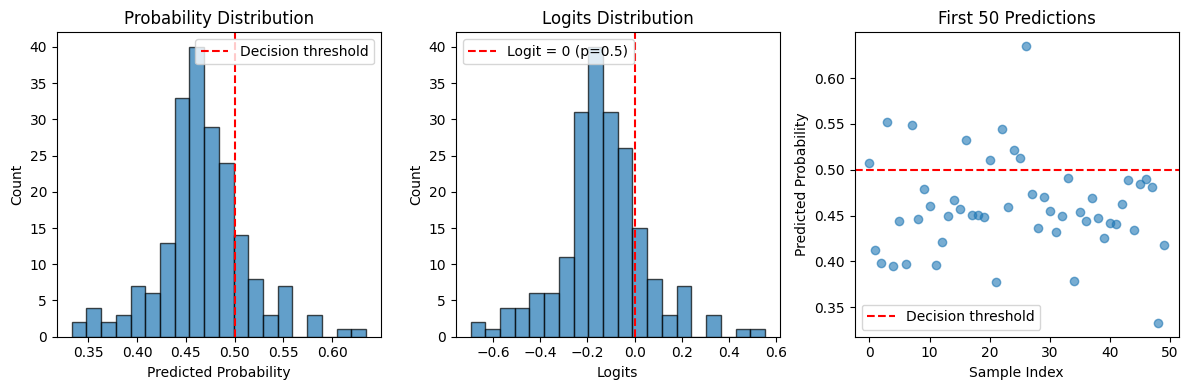

In [30]:
model.eval()
correct = 0
total = 0
predictions = []
actuals = []
logits_list = []
probabilities = []

print("=== DETAILED PREDICTION ANALYSIS ===\n")

with torch.no_grad():
    for i, (xb, yb) in enumerate(test_loader):
        xb = xb.squeeze(0)
        yb = yb.squeeze()

        logits = model(xb)
        logits_flat = logits.squeeze()
        prob = torch.sigmoid(logits_flat)
        pred = (prob > 0.5).float()
        actual = yb.float()

        predictions.append(pred.item())
        actuals.append(actual.item())
        logits_list.append(logits_flat.item())
        probabilities.append(prob.item())

        if pred == actual:
            correct += 1
        total += 1

        if i < 20:
            status = "✓ CORRECT" if pred == actual else "✗ WRONG"
            print(f"Sample {i+1:2d}: Logit: {logits_flat.item():6.3f} | "
                  f"Prob: {prob.item():.3f} | Pred: {int(pred.item())} | "
                  f"Actual: {int(actual.item())} | {status}")

print(f"\n=== SUMMARY STATISTICS ===")
print(f"Test Accuracy: {correct / total * 100:.2f}%")
print(f"Total samples: {total}")
print(f"Correct predictions: {correct}")
print(f"Wrong predictions: {total - correct}")

predictions = np.array(predictions)
actuals = np.array(actuals)
probabilities = np.array(probabilities)
logits_list = np.array(logits_list)

print(f"\n=== PREDICTION DISTRIBUTION ===")
pred_0_count = np.sum(predictions == 0)
pred_1_count = np.sum(predictions == 1)
actual_0_count = np.sum(actuals == 0)
actual_1_count = np.sum(actuals == 1)

print(f"Model predicted 0: {pred_0_count} times ({pred_0_count/total*100:.1f}%)")
print(f"Model predicted 1: {pred_1_count} times ({pred_1_count/total*100:.1f}%)")
print(f"Actual 0s in test: {actual_0_count} times ({actual_0_count/total*100:.1f}%)")
print(f"Actual 1s in test: {actual_1_count} times ({actual_1_count/total*100:.1f}%)")

print(f"\n=== BIAS ANALYSIS ===")
if pred_0_count == total:
    print("🚨 MODEL IS ALWAYS PREDICTING 0 (NEGATIVE BIAS)")
elif pred_1_count == total:
    print("🚨 MODEL IS ALWAYS PREDICTING 1 (POSITIVE BIAS)")
elif pred_0_count > total * 0.9:
    print("⚠️  MODEL HAS STRONG NEGATIVE BIAS (>90% predicting 0)")
elif pred_1_count > total * 0.9:
    print("⚠️  MODEL HAS STRONG POSITIVE BIAS (>90% predicting 1)")
else:
    print("✅ MODEL IS PREDICTING BOTH CLASSES")

print(f"\n=== PROBABILITY DISTRIBUTION ===")
print(f"Mean probability: {np.mean(probabilities):.3f}")
print(f"Std probability: {np.std(probabilities):.3f}")
print(f"Min probability: {np.min(probabilities):.3f}")
print(f"Max probability: {np.max(probabilities):.3f}")
print(f"Probabilities near 0.5 (0.4-0.6): {np.sum((probabilities >= 0.4) & (probabilities <= 0.6))}")

print(f"\n=== LOGITS DISTRIBUTION ===")
print(f"Mean logit: {np.mean(logits_list):.3f}")
print(f"Std logit: {np.std(logits_list):.3f}")
print(f"Min logit: {np.min(logits_list):.3f}")
print(f"Max logit: {np.max(logits_list):.3f}")

print(f"\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(actuals, predictions)
print("           Predicted")
print("         0    1")
print(f"Actual 0 {cm[0,0]:3d}  {cm[0,1]:3d}")
print(f"       1 {cm[1,0]:3d}  {cm[1,1]:3d}")

print(f"\n=== CLASSIFICATION REPORT ===")
print(classification_report(actuals, predictions, target_names=['Negative', 'Positive']))

print(f"\n=== MODEL BEHAVIOR DIAGNOSIS ===")
unique_probs = len(np.unique(np.round(probabilities, 3)))
unique_logits = len(np.unique(np.round(logits_list, 3)))

print(f"Unique probability values: {unique_probs}")
print(f"Unique logit values: {unique_logits}")

if unique_probs <= 3:
    print("🚨 Very few unique probabilities - model might be stuck!")
elif unique_probs <= 10:
    print("⚠️  Limited probability diversity - model might have convergence issues")
else:
    print("✅ Good probability diversity")

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(probabilities, bins=20, alpha=0.7, edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', label='Decision threshold')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Probability Distribution')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(logits_list, bins=20, alpha=0.7, edgecolor='black')
plt.axvline(0, color='red', linestyle='--', label='Logit = 0 (p=0.5)')
plt.xlabel('Logits')
plt.ylabel('Count')
plt.title('Logits Distribution')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(min(50, len(probabilities))), probabilities[:50], alpha=0.6)
plt.axhline(0.5, color='red', linestyle='--', label='Decision threshold')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability')
plt.title('First 50 Predictions')
plt.legend()

plt.tight_layout()
plt.show()